In [1]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV
from sklearn.ensemble import VotingRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')

2021-12-26 19:33:34.310114: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/usr/lib/python3/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.


In [2]:
path = 'Dataset_final/'
x1_train = pd.read_csv(path+'data_x1_train.csv')
x2_train = pd.read_csv(path+'data_x2_train.csv')
y_train = pd.read_csv(path+'data_f1_train.csv')
y_test = pd.read_csv(path+'data_f1_test.csv')
x1_test = pd.read_csv(path+'data_x1_test.csv')
x2_test = pd.read_csv(path+'data_x2_test.csv')

fv1_train = pd.read_csv(path+'Filvel_x1_train.csv')
fv1_test = pd.read_csv(path+'Filvel_x1_test.csv')
fv2_train = pd.read_csv(path+'Filvel_x2_train.csv')
fv2_test = pd.read_csv(path+'Filvel_x2_test.csv')

v1_train = pd.read_csv(path+'vel_x1_train.csv')
v1_test = pd.read_csv(path+'vel_x1_test.csv')
v2_train = pd.read_csv(path+'vel_x2_train.csv')
v2_test = pd.read_csv(path+'vel_x2_test.csv')


In [3]:
X_train = pd.DataFrame(data = np.concatenate((x1_train,x2_train,fv1_train,fv2_train,v1_train,v2_train),axis=1),columns = ['p1','p2','fv1','fv2','v1','v2'])
X_test = pd.DataFrame(data = np.concatenate((x1_test,x2_test,fv1_test,fv2_test,v1_test,v2_test),axis=1),columns = ['p1','p2','fv1','fv2','v1','v2'])
#y_train, y_test = np.array(y_train),np.array(y_test)
X_train.head()

,p1,p2,fv1,fv2,v1,v2
0,-0.0000,-0.0000,0.000000,0.000000,0.0000,0.0000
1,-0.0159,-0.0000,-0.001160,0.000000,-0.0159,0.0000
2,-0.0159,0.0171,-0.002151,0.001248,0.0000,0.0171
3,-0.0159,0.0171,-0.001837,0.002313,0.0000,0.0000
4,-0.0000,0.0329,-0.000409,0.003128,0.0159,0.0158


In [4]:
print(len(X_train),len(X_test),len(y_train))

116447 62211 116447


In [5]:
from scipy import *
from scipy.linalg import norm, pinv
import math

from matplotlib import pyplot as plt
 
class RBF:
     
    def __init__(self, indim, numCenters, outdim):
        self.indim = indim
        self.outdim = outdim
        self.numCenters = numCenters
        self.centers = [np.random.uniform(-1, 1, indim) for i in range(numCenters)]
        self.beta = 8
        self.W = np.random.random((self.numCenters, self.outdim))
         
    def _basisfunc(self, c, d):
        assert len(d) == self.indim
        return norm(c-d)**3
     
    def _calcAct(self, X):
        # calculate activations of RBFs
        G = np.zeros((X.shape[0], self.numCenters), float)
        for ci, c in enumerate(self.centers):
            for xi, x in enumerate(X):
                G[xi,ci] = self._basisfunc(c, x)
        return G
     
    def train(self, X, Y):
        """ X: matrix of dimensions n x indim 
            y: column vector of dimension n x 1 """
         
        # choose random center vectors from training set
        rnd_idx = np.random.permutation(X.shape[0])[:self.numCenters]
        self.centers = [X[i,:] for i in rnd_idx]
         
        #print("center", self.centers)
        # calculate activations of RBFs
        G = self._calcAct(X)
        #print(G)
         
        # calculate output weights (pseudoinverse)
        self.W = np.dot(pinv(G), Y)
         
    def test(self, X):
        """ X: matrix of dimensions n x indim """
         
        G = self._calcAct(X)
        Y = np.dot(G, self.W)
        return Y

In [9]:
x_train,x_test = np.array(X_train),np.array(X_test)
def get_results():
    t1 = datetime.now()
    rf = RandomForestRegressor()
    rf.fit(x_train,y_train)
    t2 = datetime.now()
    print('Time taken by Random Forest',t2-t1)
    
    y1_pred = rf.predict(x_test)
    y1 = y1_pred
    print('Root Mean Squared error of Random Forest',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error = []
    for i in range(len(y_test)):
        error.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error))
    print('Maximum Error =',max(error))
    error1 = sorted(error)
    print('Median Value of Error =',error1[len(error)//2])
    
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),y1[:6000], label = 'Random Forest')
    plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
    plt.legend()
    plt.xlabel('Time (in ms)')
    plt.ylabel('Force')
    plt.title('Models prediction comparison')
    plt.show()
    
    
    # RBF MODEL
    rbf = RBF(6, 30, 1)
    t1 = datetime.now()
    rbf.train(x_train, y_train)
    t2 = datetime.now()
    
    print('\n\nTime taken by RBF Model: ',t2-t1)
    y1_pred = rbf.test(x_test)
    y2 = y1_pred
    print('Root mean square error of RBF Model: ',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error5 = []
    for i in range(len(y_test)):
        error5.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error5))
    print('Maximum Error =',max(error5))
    error6 = sorted(error5)
    print('Median Value of Error =',error6[len(error5)//2])
    
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),y2[:6000], label = 'RBF Model')
    plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
    plt.legend()
    plt.xlabel('Time (in ms)')
    plt.ylabel('Force')
    plt.title('Models prediction comparison')
    plt.show()
    
    # SVR MODEL
    t1 = datetime.now()
    clf = make_pipeline(StandardScaler(), SVR(kernel = 'rbf'))
    clf.fit(x_train,y_train)
    t2 = datetime.now()

    print('\n\nTime taken by SVR Model: ',t2-t1)
    y1_pred = clf.predict(x_test)
    y4 = y1_pred
    print('Root mean square error of SVR Model: ',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error7 = []
    for i in range(len(y_test)):
        error7.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error7))
    print('Maximum Error =',max(error7))
    error8 = sorted(error7)
    print('Median Value of Error =',error8[len(error8)//2])
    
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),y4[:6000], label = 'SVR')
    plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
    plt.legend()
    plt.xlabel('Time (in ms)')
    plt.ylabel('Force')
    plt.title('Models prediction comparison')
    plt.show()
    
    # GRADIENT BOOSTING
    gb = GradientBoostingRegressor()
    t1 = datetime.now()
    gb.fit(x_train,y_train)
    t2 = datetime.now()
    print('Time taken by Gradient Boosting:',t2-t1)

    y1_pred = gb.predict(x_test)
    print('Root mean square error of Gradient Boosting Model: ',sqrt(mean_squared_error(y_test,y1_pred)))
    y3 = y1_pred
    
    error9 = []
    for i in range(len(y_test)):
        error9.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error9))
    print('Maximum Error =',max(error9))
    error8 = sorted(error7)
    print('Median Value of Error =',error8[len(error9)//2])
    
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),y3[:6000], label = 'Gradient Boosting')
    plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
    plt.legend()
    plt.xlabel('Time (in ms)')
    plt.ylabel('Force')
    plt.title('Models prediction comparison')
    plt.show()
    
    
    # COMPARISON
    plt.plot(list(range(len(y1_pred))),error5, label = 'Error of RBF Model')
    plt.plot(list(range(len(y1_pred))),error, label = 'Error of Random Forest')
    plt.plot(list(range(len(y1_pred))),error7, label = 'Error of SVR Model')
    plt.plot(list(range(len(y1_pred))),error9, label = 'Error of Gradient Boosting Model')
    plt.legend()
    plt.title('Error as a function of time')
    plt.show()
    
    # closer view at initial points
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),error5[:6000], label = 'RBF Model')
    plt.plot(list(range(6000)),error[:6000], label = 'Random Forest')
    plt.plot(list(range(6000)),error7[:6000], label = 'SVR Model')
    plt.plot(list(range(6000)),error9[:6000], label = 'Gradient Boosting Model')
    plt.legend()
    plt.title('Error as a function of time')
    plt.show()
    
    return error,error5,error7, error9

# Results

Time taken by Random Forest 0:01:09.805151
Root Mean Squared error of Random Forest 0.05998225538801315
Minimum Error = 9.99999997919332e-07
Maximum Error = 1.000445000000001
Median Value of Error = 0.018249000000000015


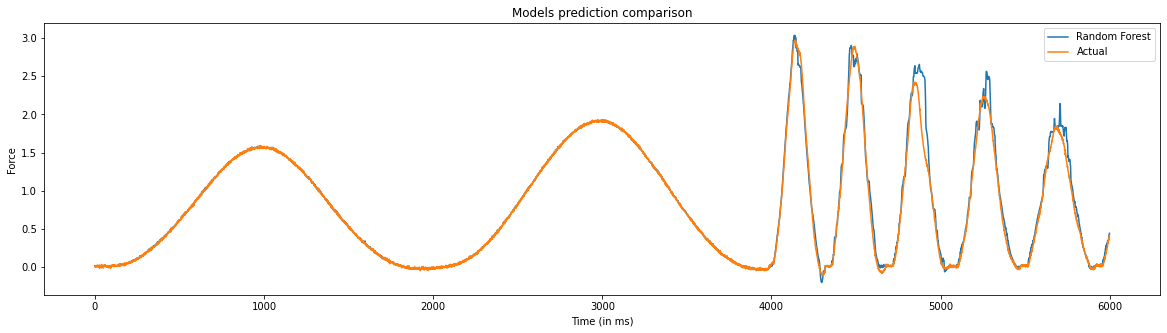



Time taken by RBF Model:  0:00:32.413665
Root mean square error of RBF Model:  0.060334613243108716
Minimum Error = [3.95364434e-08]
Maximum Error = [0.66922234]
Median Value of Error = [0.02502908]


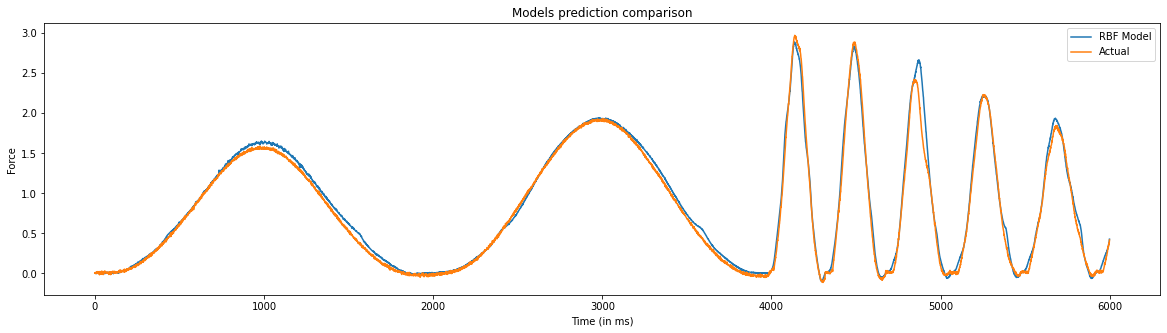



Time taken by SVR Model:  0:00:37.384581
Root mean square error of SVR Model:  0.09590484397446929
Minimum Error = 1.5250782194053958e-07
Maximum Error = 1.3115841671476056
Median Value of Error = 0.026324459438919923


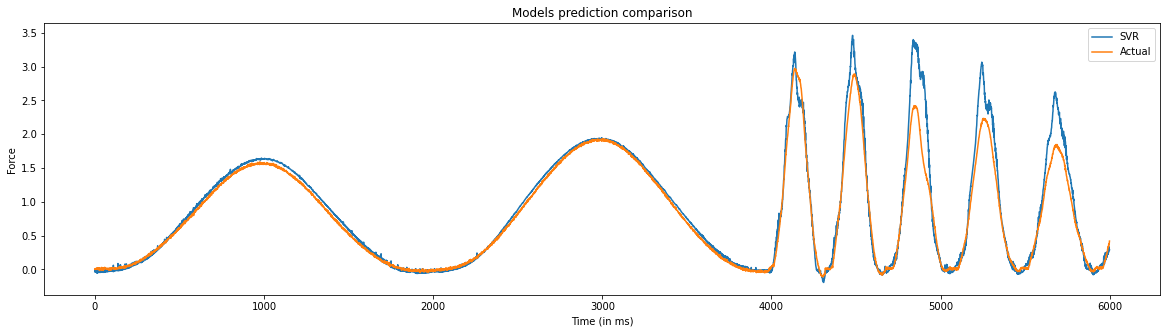

Time taken by Gradient Boosting: 0:00:20.392835
Root mean square error of Gradient Boosting Model:  0.05272755360478404
Minimum Error = 4.938433619053328e-07
Maximum Error = 0.9828922859169313
Median Value of Error = 0.026324459438919923


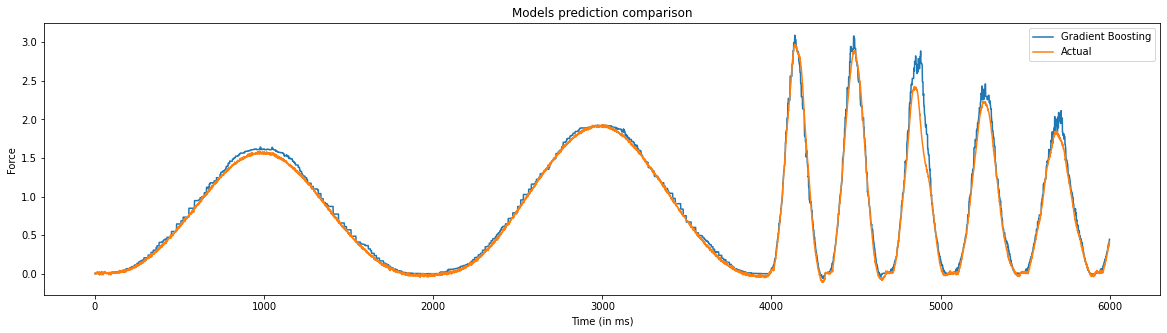

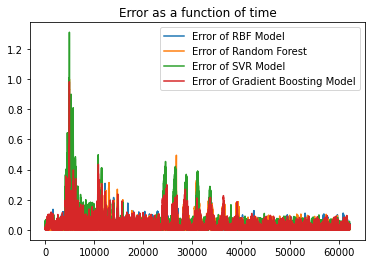

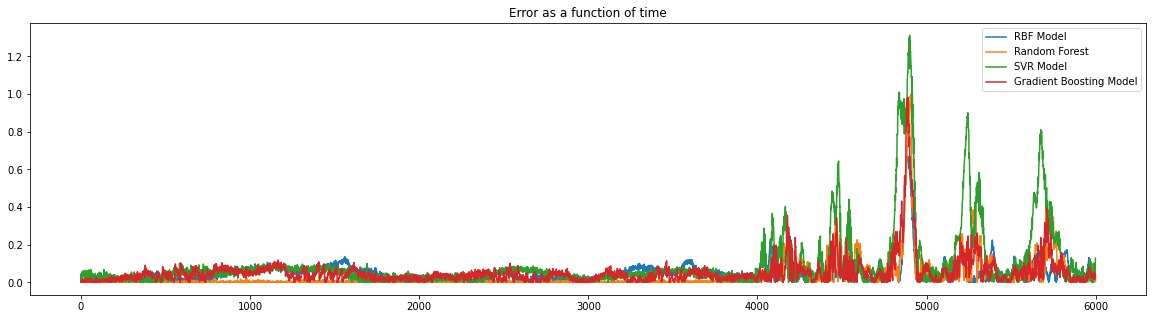

In [10]:
error, error5, error7, error9 = get_results()

In [11]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor()
t1 = datetime.now()
cat.fit(x_train,y_train)
t2 = datetime.now()

Learning rate set to 0.086822
0:	learn: 0.9241095	total: 72.6ms	remaining: 1m 12s
1:	learn: 0.8487647	total: 78.2ms	remaining: 39s
2:	learn: 0.7790980	total: 83.7ms	remaining: 27.8s
3:	learn: 0.7158351	total: 92.6ms	remaining: 23.1s
4:	learn: 0.6579791	total: 97.5ms	remaining: 19.4s
5:	learn: 0.6047179	total: 104ms	remaining: 17.2s
6:	learn: 0.5558452	total: 109ms	remaining: 15.4s
7:	learn: 0.5112268	total: 115ms	remaining: 14.2s
8:	learn: 0.4705963	total: 120ms	remaining: 13.2s
9:	learn: 0.4339483	total: 129ms	remaining: 12.8s
10:	learn: 0.4002370	total: 136ms	remaining: 12.2s
11:	learn: 0.3697315	total: 140ms	remaining: 11.6s
12:	learn: 0.3415127	total: 147ms	remaining: 11.2s
13:	learn: 0.3160719	total: 152ms	remaining: 10.7s
14:	learn: 0.2920382	total: 157ms	remaining: 10.3s
15:	learn: 0.2703743	total: 164ms	remaining: 10.1s
16:	learn: 0.2505343	total: 172ms	remaining: 9.94s
17:	learn: 0.2324233	total: 180ms	remaining: 9.81s
18:	learn: 0.2158463	total: 185ms	remaining: 9.56s
19:	lea

In [12]:
print('Time taken by Cat Boosting:',t2-t1)

y_pred = cat.predict(x_test)
print('Root mean square error of Cat Boost Model: ',sqrt(mean_squared_error(y_test,y_pred)))

Time taken by Cat Boosting: 0:00:06.615837
Root mean square error of Cat Boost Model:  0.04184460292838573


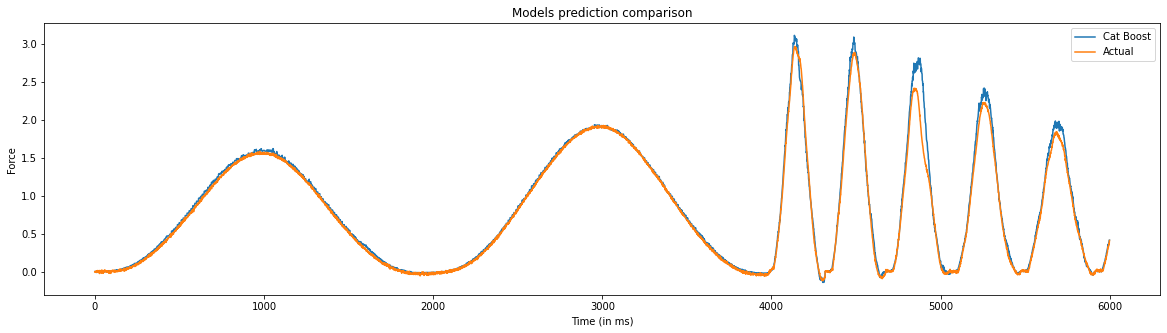

In [13]:
plt.figure(figsize=(20,5))
plt.plot(list(range(6000)),y_pred[:6000], label = 'Cat Boost')
plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
plt.legend()
plt.xlabel('Time (in ms)')
plt.ylabel('Force')
plt.title('Models prediction comparison')
plt.show()

In [15]:
error_cat = []
for i in range(len(y_test)):
        error_cat.append(abs(y_pred[i]-y_test.iloc[i,0]))
print('Minimum Error =',min(error_cat))
print('Maximum Error =',max(error_cat))
error8 = sorted(error_cat)
print('Median Value of Error =',error8[len(error8)//2])

Minimum Error = 2.67127077790974e-07
Maximum Error = 0.8863306721478648
Median Value of Error = 0.015605917866663765


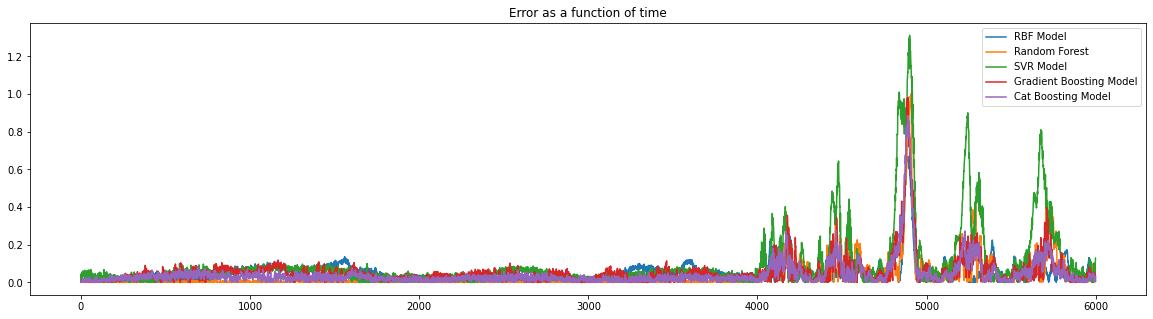

In [16]:
plt.figure(figsize=(20,5))
plt.plot(list(range(6000)),error5[:6000], label = 'RBF Model')
plt.plot(list(range(6000)),error[:6000], label = 'Random Forest')
plt.plot(list(range(6000)),error7[:6000], label = 'SVR Model')
plt.plot(list(range(6000)),error9[:6000], label = 'Gradient Boosting Model')
plt.plot(list(range(6000)),error_cat[:6000], label = 'Cat Boosting Model')
plt.legend()
plt.title('Error as a function of time')
plt.show()